In [1]:
import pandas
import seaborn
import time

from lib.compiler import Compiler
from lib.models.generic_v0.model import mappable_params

from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

from lib.models.generic_v1 import protocols as g1
from lib.models.generic_v1.model import SingleAgent as G1Model

from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model

In [2]:
network = mappable_params

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


# related work baseline


def _():
    pass

    add_model(
        scenario="reference",
        model="fc16sapirshtein",
        force_consider_own=True,
        merge_isomorphic=True,
        truncate_common_chain=True,
        collect_garbage=True,
        reward_common_chain=True,
        protocol="bitcoin",
        implicit_mdp=lambda c: FC16Sapirshtein(
            **network, maximum_fork_length=c
        ),  # TODO implement DAG size cutoff for this model
    )

    add_model(
        scenario="reference-v0",
        model="generic_0",
        force_consider_own=True,
        merge_isomorphic=True,
        truncate_common_chain=True,
        collect_garbage=True,
        reward_common_chain=True,
        protocol="bitcoin",
        implicit_mdp=lambda c: G0Model(
            G0Bitcoin(),
            **network,
            maximum_size=c,
            force_consider_own=True,
            merge_isomorphic=True,
        ),
    )


# our baseline: garbage collection + common chain truncation
# we want to compare to:
# - no common chain truncation (all infinite)
# - no garbage collection (infinite for protocols that allow stale blocks)
# - plus force-consider-own
# - plus merge-isomorphic
# - plus both


def add_scenario(
    scenario,
    *,
    collect_garbage=True,
    truncate_common_chain=True,
    force_consider_own=False,
    merge_isomorphic=False,
):
    def f(protocol_s, protocol_C, **protocol_args):
        model_args = dict(
            force_consider_own=force_consider_own,
            merge_isomorphic=merge_isomorphic,
            truncate_common_chain=truncate_common_chain,
            collect_garbage=collect_garbage,
            reward_common_chain=False,
        )
        add_model(
            scenario=scenario,
            model="generic_1",
            protocol=protocol_s,
            **model_args,
            implicit_mdp=lambda c: G1Model(
                protocol_C,
                **protocol_args,
                **network,
                **model_args,
                dag_size_cutoff=c,
            ),
        )

    f("bitcoin", g1.Bitcoin)
    f("ethereum_3", g1.Ethereum, h=3)
    f("byzantium_3", g1.Byzantium, h=3)
    f("ghostdag_3", g1.Ghostdag, k=3)
    f("parallel_3", g1.Parallel, k=3)


add_scenario("baseline")
add_scenario("w/o collect garbage", collect_garbage=False)
add_scenario("w/o truncate", truncate_common_chain=False)
add_scenario("w/ force consider", force_consider_own=True)
add_scenario("w/ normalization", merge_isomorphic=True)
add_scenario("w/ both", force_consider_own=True, merge_isomorphic=True)

models = pandas.DataFrame(models)
models

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain
0,baseline,generic_1,bitcoin,False,False,True,True,False
1,baseline,generic_1,ethereum_3,False,False,True,True,False
2,baseline,generic_1,byzantium_3,False,False,True,True,False
3,baseline,generic_1,ghostdag_3,False,False,True,True,False
4,baseline,generic_1,parallel_3,False,False,True,True,False
5,w/o collect garbage,generic_1,bitcoin,False,False,True,False,False
6,w/o collect garbage,generic_1,ethereum_3,False,False,True,False,False
7,w/o collect garbage,generic_1,byzantium_3,False,False,True,False,False
8,w/o collect garbage,generic_1,ghostdag_3,False,False,True,False,False
9,w/o collect garbage,generic_1,parallel_3,False,False,True,False,False


In [3]:
!mkdir -p 5-generated-mdps

In [4]:
from IPython.display import display, clear_output
import gc
import psutil
import pickle
import gzip

max_size = 100000
# max_size = 10000
aborts = []
size_log = []


def get_rss():
    gc.collect()
    return psutil.Process().memory_info().rss / 1024**3  # GiB


for idx, row in models.iterrows():
    dag_size_limit = 1
    while True:
        dag_size_limit += 1
        m = implicit_mdps[idx](dag_size_limit)
        c = Compiler(m)
        start_time = time.monotonic()
        while not_done := c.explore(steps=1000):
            if c.n_states > max_size:
                break

        info = row.to_dict() | dict(
            dag_size_limit=dag_size_limit,
            size=c.n_states,
            time_spent=time.monotonic() - start_time,
            rss=get_rss(),
        )

        # report to stdout
        print(
            "\r"
            + "\t".join(
                [
                    f"{k}: {info[k]}"
                    for k in [
                        "scenario",
                        "protocol",
                        "dag_size_limit",
                        "size",
                        "time_spent",
                        "rss",
                    ]
                ]
                + [f"abort: {not_done}                      "]
            ),
            end="",
        )

        if not_done:
            aborts.append(info)
            break
        else:
            mdp_key = format(abs(hash(frozenset(info.items()))), "08x")[0:8]
            size_log.append(info | dict(mdp=mdp_key))
            with gzip.open(f"5-generated-mdps/mdp-{mdp_key}.pkl.gz", "wb") as f:
                pickle.dump(c.mdp(finish_exploration=False), f)

size_log = pandas.DataFrame(size_log)
aborts = pandas.DataFrame(aborts)

size_log.to_pickle("5-generated-mdps/success.pkl.gz")
aborts.to_pickle("5-generated-mdps/fail.pkl.gz")

scenario: baseline	protocol: bitcoin	dag_size_limit: 2	size: 6	time_spent: 0.0026832549992832355	rss: 0.1734466552734375	abort: False                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 3	size: 34	time_spent: 0.011136455002997536	rss: 0.1739349365234375	abort: False                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 4	size: 267	time_spent: 0.09194788400054676	rss: 0.1757659912109375	abort: False                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 5	size: 2332	time_spent: 1.3381185079997522	rss: 0.1906585693359375	abort: False                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 6	size: 21327	time_spent: 14.33759013999952	rss: 0.3447113037109375	abort: False                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 7	size: 100733	time_spent: 63.25032387400279	rss: 0.9973564147949219	abort: True                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 3	size: 45	time_spent: 0.01728394200472394	rss: 0.2185821533203125	abort: False                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 4	size: 327	time_spent: 0.1261601009973674	rss: 0.2178497314453125	abort: False                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 5	size: 2981	time_spent: 1.602048824999656	rss: 0.21763992309570312	abort: False                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 6	size: 32961	time_spent: 23.533842345001176	rss: 0.4446907043457031	abort: False                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 7	size: 100084	time_spent: 68.06797834199824	rss: 0.9778099060058594	abort: True                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 3	size: 45	time_spent: 0.018725132002145983	rss: 0.2252044677734375	abort: False                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 4	size: 327	time_spent: 0.13646379000419984	rss: 0.2244720458984375	abort: False                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 5	size: 2981	time_spent: 1.7113210770039586	rss: 0.22376632690429688	abort: False                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 6	size: 33016	time_spent: 25.439894208000624	rss: 0.4452018737792969	abort: False                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 7	size: 100073	time_spent: 72.05599050300225	rss: 0.977630615234375	abort: True                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 3	size: 45	time_spent: 0.01915027100039879	rss: 0.227325439453125	abort: False                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 4	size: 352	time_spent: 0.1696431240052334	rss: 0.227081298828125	abort: False                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 5	size: 3712	time_spent: 2.6395994009944843	rss: 0.226837158203125	abort: False                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 6	size: 46966	time_spent: 42.39117695699679	rss: 0.543609619140625	abort: False                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 7	size: 100114	time_spent: 77.56531772499875	rss: 0.9434738159179688	abort: True                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 3	size: 90	time_spent: 0.03069949199561961	rss: 0.285369873046875	abort: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 4	size: 206	time_spent: 0.07690048700169427	rss: 0.282928466796875	abort: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 5	size: 1189	time_spent: 0.6203257189990836	rss: 0.282928466796875	abort: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 6	size: 9122	time_spent: 5.645695794002677	rss: 0.280853271484375	abort: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 7	size: 83355	time_spent: 59.96182571999816	rss: 0.9359283447265625	abort: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 8	size: 100730	time_spent: 70.12195159600378	rss: 1.0871353149414062	abort: True                      

scenario: w/o collect garbage	protocol: bitcoin	dag_size_limit: 2	size: 6	time_spent: 0.0016617639994365163	rss: 0.244171142578125	abort: False                      

scenario: w/o collect garbage	protocol: bitcoin	dag_size_limit: 3	size: 100674	time_spent: 42.28143715600163	rss: 1.410797119140625	abort: True                      

scenario: w/o collect garbage	protocol: ethereum_3	dag_size_limit: 3	size: 85	time_spent: 0.022645851997367572	rss: 0.24593353271484375	abort: False                      

scenario: w/o collect garbage	protocol: ethereum_3	dag_size_limit: 4	size: 465	time_spent: 0.12220328200055519	rss: 0.24568939208984375	abort: False                      

scenario: w/o collect garbage	protocol: ethereum_3	dag_size_limit: 5	size: 100667	time_spent: 50.17876095700194	rss: 1.3817977905273438	abort: True                      

scenario: w/o collect garbage	protocol: byzantium_3	dag_size_limit: 3	size: 85	time_spent: 0.025612880002881866	rss: 0.24265670776367188	abort: False                      

scenario: w/o collect garbage	protocol: byzantium_3	dag_size_limit: 4	size: 465	time_spent: 0.13602281100611435	rss: 0.24246978759765625	abort: False                      

scenario: w/o collect garbage	protocol: byzantium_3	dag_size_limit: 5	size: 100608	time_spent: 60.31867181099369	rss: 1.3805313110351562	abort: True                      

scenario: w/o collect garbage	protocol: ghostdag_3	dag_size_limit: 3	size: 45	time_spent: 0.014651684003183618	rss: 0.238800048828125	abort: False                      

scenario: w/o collect garbage	protocol: ghostdag_3	dag_size_limit: 4	size: 367	time_spent: 0.14250820300367195	rss: 0.238067626953125	abort: False                      

scenario: w/o collect garbage	protocol: ghostdag_3	dag_size_limit: 5	size: 4107	time_spent: 2.3810357230031514	rss: 0.237823486328125	abort: False                      

scenario: w/o collect garbage	protocol: ghostdag_3	dag_size_limit: 6	size: 56277	time_spent: 41.83982773799653	rss: 0.610015869140625	abort: False                      

scenario: w/o collect garbage	protocol: ghostdag_3	dag_size_limit: 7	size: 100407	time_spent: 54.97101937299885	rss: 0.953399658203125	abort: True                      

scenario: w/o collect garbage	protocol: parallel_3	dag_size_limit: 3	size: 90	time_spent: 0.020412964004208334	rss: 0.30786895751953125	abort: False                      

scenario: w/o collect garbage	protocol: parallel_3	dag_size_limit: 4	size: 206	time_spent: 0.0480125690010027	rss: 0.30493927001953125	abort: False                      

scenario: w/o collect garbage	protocol: parallel_3	dag_size_limit: 5	size: 100342	time_spent: 37.864883834001375	rss: 1.4156684875488281	abort: True                      

scenario: w/o truncate	protocol: bitcoin	dag_size_limit: 2	size: 100680	time_spent: 53.134271814000385	rss: 1.6001167297363281	abort: True                      

scenario: w/o truncate	protocol: ethereum_3	dag_size_limit: 2	size: 100680	time_spent: 73.8499095599982	rss: 1.6108589172363281	abort: True                      

scenario: w/o truncate	protocol: byzantium_3	dag_size_limit: 2	size: 100680	time_spent: 86.28941188500175	rss: 1.6109809875488281	abort: True                      

scenario: w/o truncate	protocol: ghostdag_3	dag_size_limit: 2	size: 100680	time_spent: 108.66699104999861	rss: 1.6109809875488281	abort: True                      

scenario: w/o truncate	protocol: parallel_3	dag_size_limit: 2	size: 100680	time_spent: 60.83465647000412	rss: 1.6109809875488281	abort: True                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 4	size: 58	time_spent: 0.020301767995988484	rss: 0.2690010070800781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 5	size: 186	time_spent: 0.07776948000537232	rss: 0.2687568664550781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 6	size: 549	time_spent: 0.251835940995079	rss: 0.2685127258300781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 7	size: 1650	time_spent: 0.978897043998586	rss: 0.2682685852050781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 8	size: 4968	time_spent: 3.3691426890000002	rss: 0.2672920227050781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 9	size: 15172	time_spent: 12.808679964997282	rss: 0.3609199523925781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 10	size: 46756	time_spent: 43.83195129499654	rss: 0.7016181945800781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 11	size: 100126	time_spent: 92.14839389800181	rss: 1.2978172302246094	abort: True                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 4	size: 78	time_spent: 0.03479126899765106	rss: 0.2721214294433594	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 5	size: 290	time_spent: 0.15080424799816683	rss: 0.27196502685546875	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 6	size: 1179	time_spent: 0.7503224050014978	rss: 0.2714805603027344	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 7	size: 4123	time_spent: 2.993852068000706	rss: 0.2687950134277344	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 8	size: 15257	time_spent: 12.558363420001115	rss: 0.3531074523925781	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 9	size: 57506	time_spent: 53.6984122740032	rss: 0.7858467102050781	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 10	size: 100450	time_spent: 92.19314544300141	rss: 1.2316474914550781	abort: True                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 4	size: 78	time_spent: 0.0382837049983209	rss: 0.2740364074707031	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 5	size: 290	time_spent: 0.16755328600265784	rss: 0.2740364074707031	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 6	size: 1109	time_spent: 0.7864871259953361	rss: 0.2737922668457031	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 7	size: 3850	time_spent: 3.1209905529976822	rss: 0.2735481262207031	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 8	size: 14595	time_spent: 13.819144706998486	rss: 0.3484992980957031	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 9	size: 54285	time_spent: 56.96143772800133	rss: 0.7537727355957031	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 10	size: 100686	time_spent: 101.91893334099586	rss: 1.2354621887207031	abort: True                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 4	size: 84	time_spent: 0.04703657999925781	rss: 0.2738838195800781	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 5	size: 350	time_spent: 0.2652067090020864	rss: 0.2738838195800781	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 6	size: 1527	time_spent: 1.5061838239998906	rss: 0.2737236022949219	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 7	size: 6739	time_spent: 8.836622121998516	rss: 0.27306365966796875	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 8	size: 31192	time_spent: 51.56245204600418	rss: 0.49388885498046875	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 9	size: 100585	time_spent: 142.31056190600066	rss: 1.143463134765625	abort: True                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 3	size: 69	time_spent: 0.02668128899676958	rss: 0.32312774658203125	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 4	size: 119	time_spent: 0.044582532995264046	rss: 0.31678009033203125	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 5	size: 470	time_spent: 0.18856657699507196	rss: 0.31612396240234375	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 6	size: 2175	time_spent: 1.1541010879955138	rss: 0.31563568115234375	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 7	size: 10337	time_spent: 5.9064874820032855	rss: 0.31160736083984375	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 8	size: 43562	time_spent: 31.3708029240006	rss: 0.6278915405273438	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 9	size: 100662	time_spent: 76.94393035000394	rss: 1.2234725952148438	abort: True                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 3	size: 45	time_spent: 0.018109895994712133	rss: 0.28699493408203125	abort: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 4	size: 198	time_spent: 0.09278364900092129	rss: 0.28577423095703125	abort: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 5	size: 1090	time_spent: 0.7619154069980141	rss: 0.28577423095703125	abort: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 6	size: 5724	time_spent: 5.340372530998138	rss: 0.2853050231933594	abort: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 7	size: 31532	time_spent: 38.03460650600027	rss: 0.4910697937011719	abort: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 8	size: 100188	time_spent: 117.66852366000239	rss: 1.1208305358886719	abort: True                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 3	size: 78	time_spent: 0.0407400600015535	rss: 0.2910957336425781	abort: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 4	size: 231	time_spent: 0.1260842230039998	rss: 0.2898750305175781	abort: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 5	size: 1480	time_spent: 1.0860908719987492	rss: 0.2897529602050781	abort: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 6	size: 10293	time_spent: 9.721062632001122	rss: 0.2954559326171875	abort: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 7	size: 77694	time_spent: 83.95786803899682	rss: 0.8893280029296875	abort: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 8	size: 100621	time_spent: 112.28765002999717	rss: 1.0727500915527344	abort: True                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 3	size: 78	time_spent: 0.04482438800187083	rss: 0.29662322998046875	abort: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 4	size: 231	time_spent: 0.1407595510027022	rss: 0.29622650146484375	abort: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 5	size: 1480	time_spent: 1.2082021960013662	rss: 0.29549407958984375	abort: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 6	size: 9879	time_spent: 9.791491135001706	rss: 0.2941322326660156	abort: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 7	size: 72420	time_spent: 85.22823968099692	rss: 0.8377113342285156	abort: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 8	size: 100298	time_spent: 115.96436328600248	rss: 1.0764732360839844	abort: True                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 3	size: 41	time_spent: 0.021287730000040028	rss: 0.2950325012207031	abort: False                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 4	size: 228	time_spent: 0.14042744800099172	rss: 0.2947883605957031	abort: False                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 5	size: 1581	time_spent: 1.3137386899979902	rss: 0.2945442199707031	abort: False                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 6	size: 12644	time_spent: 14.29504597500636	rss: 0.3094367980957031	abort: False                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 7	size: 100085	time_spent: 120.83389442499902	rss: 1.0172004699707031	abort: True                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 3	size: 68	time_spent: 0.030468760000076145	rss: 0.3298797607421875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 4	size: 152	time_spent: 0.07895802799612284	rss: 0.3271942138671875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 5	size: 478	time_spent: 0.33364850399811985	rss: 0.3271942138671875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 6	size: 1677	time_spent: 1.4720743729994865	rss: 0.3269500732421875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 7	size: 6618	time_spent: 7.104742196999723	rss: 0.3229217529296875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 8	size: 31452	time_spent: 37.03936106900073	rss: 0.5139656066894531	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 9	size: 100258	time_spent: 130.2486835420059	rss: 1.2200202941894531	abort: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 4	size: 45	time_spent: 0.02330623300076695	rss: 0.2963218688964844	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 5	size: 120	time_spent: 0.07584840700292261	rss: 0.2955894470214844	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 6	size: 300	time_spent: 0.21804988000076264	rss: 0.2951011657714844	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 7	size: 760	time_spent: 0.6283115779951913	rss: 0.2951011657714844	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 8	size: 1959	time_spent: 2.046754910996242	rss: 0.2946128845214844	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 9	size: 5153	time_spent: 5.9951577659958275	rss: 0.29244232177734375	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 10	size: 13794	time_spent: 18.672317243996076	rss: 0.35945892333984375	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 11	size: 37322	time_spent: 57.58464277299936	rss: 0.6339950561523438	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 12	size: 100344	time_spent: 168.73545526999806	rss: 1.36810302734375	abort: True                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 4	size: 56	time_spent: 0.03447258500091266	rss: 0.300872802734375	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 5	size: 186	time_spent: 0.13298573900101474	rss: 0.299896240234375	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 6	size: 596	time_spent: 0.4908930270030396	rss: 0.299652099609375	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 7	size: 1794	time_spent: 1.7764940289998776	rss: 0.299407958984375	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 8	size: 5535	time_spent: 6.019653846000438	rss: 0.2985649108886719	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 9	size: 17089	time_spent: 21.3870762009974	rss: 0.3843803405761719	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 10	size: 51668	time_spent: 71.74403787500341	rss: 0.7515678405761719	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 11	size: 100435	time_spent: 148.004354703	rss: 1.2864799499511719	abort: True                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 4	size: 56	time_spent: 0.0377685109997401	rss: 0.3068351745605469	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 5	size: 186	time_spent: 0.14602902899787296	rss: 0.3059539794921875	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 6	size: 572	time_spent: 0.4895255859955796	rss: 0.3057098388671875	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 7	size: 1705	time_spent: 1.7684749039981398	rss: 0.3054656982421875	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 8	size: 5187	time_spent: 6.32366271099454	rss: 0.3033905029296875	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 9	size: 15630	time_spent: 21.47756184500031	rss: 0.3691902160644531	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 10	size: 47341	time_spent: 73.54527588999917	rss: 0.7036628723144531	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 11	size: 100638	time_spent: 164.47073755600286	rss: 1.2975349426269531	abort: True                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 4	size: 57	time_spent: 0.04029368799820077	rss: 0.3074913024902344	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 5	size: 184	time_spent: 0.16255252100381767	rss: 0.3067588806152344	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 6	size: 604	time_spent: 0.6545411970000714	rss: 0.3067588806152344	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 7	size: 2026	time_spent: 2.9358502850009245	rss: 0.3067588806152344	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 8	size: 6914	time_spent: 12.99318217599648	rss: 0.3052940368652344	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 9	size: 23944	time_spent: 54.285378758999286	rss: 0.44232177734375	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 10	size: 83952	time_spent: 230.6756035809958	rss: 1.08209228515625	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 11	size: 100819	time_spent: 232.06886127200414	rss: 1.2115135192871094	abort: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 3	size: 50	time_spent: 0.02618706799694337	rss: 0.3219413757324219	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 5	size: 195	time_spent: 0.124688072995923	rss: 0.3166465759277344	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 6	size: 492	time_spent: 0.34915979300421895	rss: 0.3159141540527344	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 7	size: 1330	time_spent: 1.116261110000778	rss: 0.3156700134277344	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 8	size: 3670	time_spent: 3.567484279999917	rss: 0.3103904724121094	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 9	size: 9792	time_spent: 11.709092197997961	rss: 0.3086814880371094	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 10	size: 24547	time_spent: 34.24088516199845	rss: 0.4529685974121094	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 11	size: 59002	time_spent: 93.07161706299667	rss: 0.8689842224121094	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 12	size: 100259	time_spent: 169.2599460019992	rss: 1.3873672485351562	abort: True                      

In [5]:
aborts

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss
0,baseline,generic_1,bitcoin,False,False,True,True,False,7,100733,63.250324,0.997356
1,baseline,generic_1,ethereum_3,False,False,True,True,False,7,100084,68.067978,0.977810
2,baseline,generic_1,byzantium_3,False,False,True,True,False,7,100073,72.055991,0.977631
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,7,100114,77.565318,0.943474
4,baseline,generic_1,parallel_3,False,False,True,True,False,8,100730,70.121952,1.087135
5,w/o collect garbage,generic_1,bitcoin,False,False,True,False,False,3,100674,42.281437,1.410797
6,w/o collect garbage,generic_1,ethereum_3,False,False,True,False,False,5,100667,50.178761,1.381798
7,w/o collect garbage,generic_1,byzantium_3,False,False,True,False,False,5,100608,60.318672,1.380531
8,w/o collect garbage,generic_1,ghostdag_3,False,False,True,False,False,7,100407,54.971019,0.953400
9,w/o collect garbage,generic_1,parallel_3,False,False,True,False,False,5,100342,37.864884,1.415668


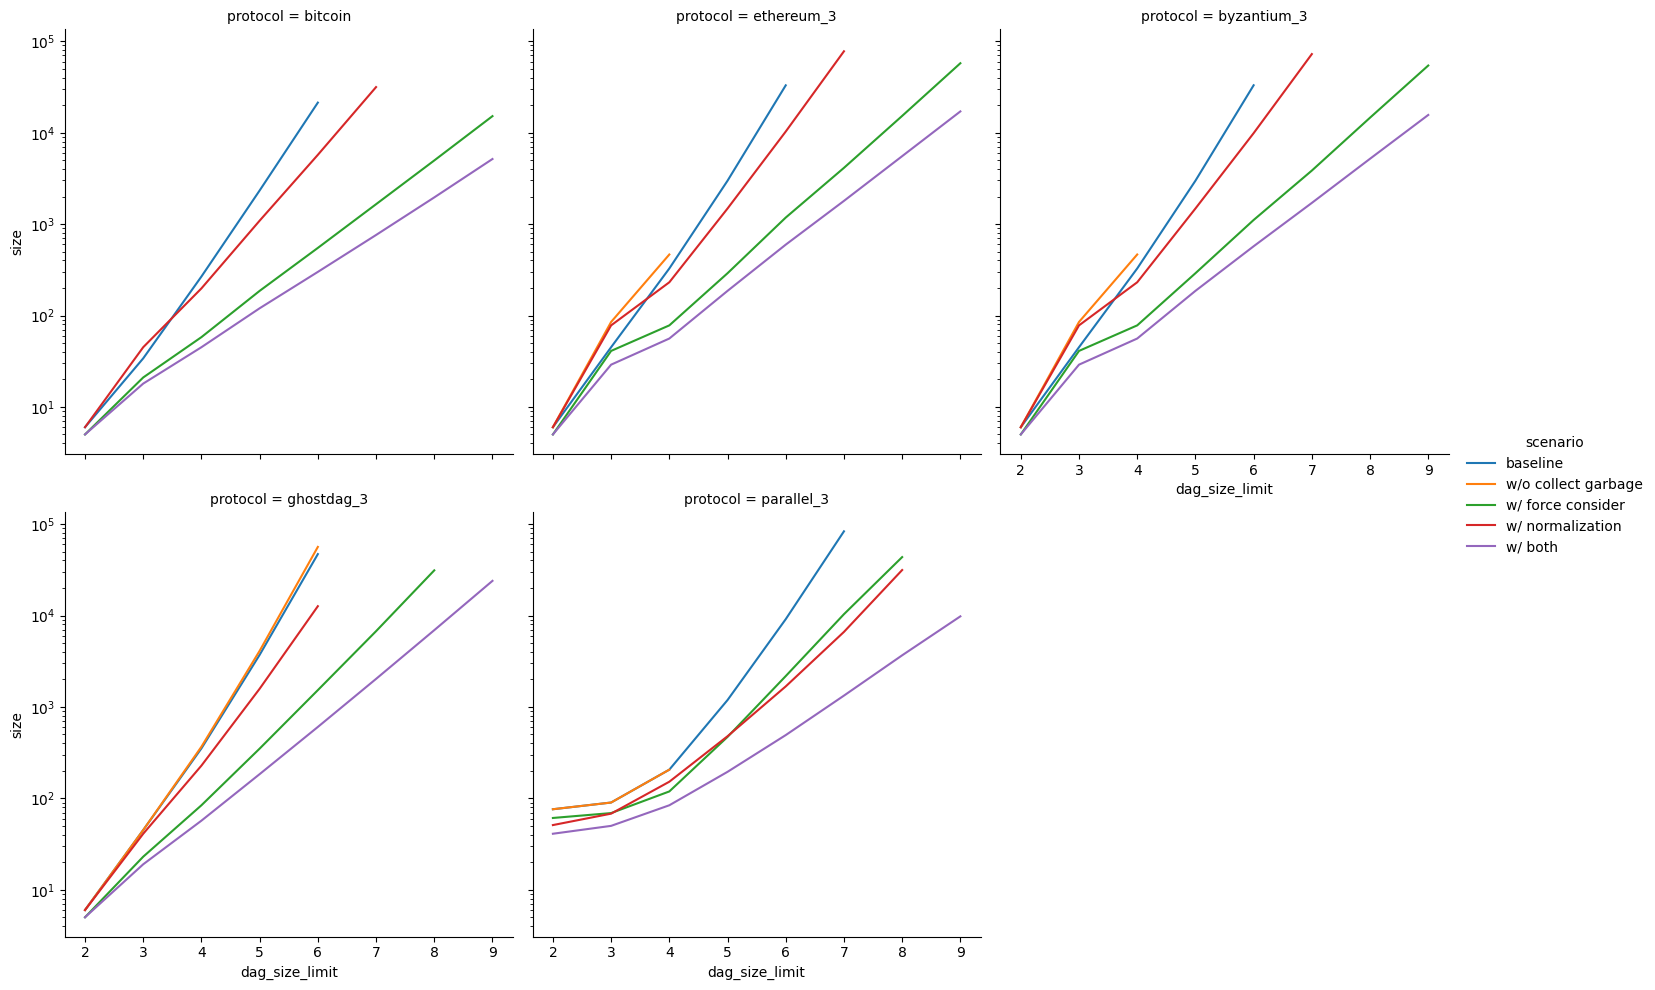

In [6]:
seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")